In [103]:
# Data-handling libraries
import pandas as pd
import scipy.sparse

# Feature extraction/transformation libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.decomposition import PCA

# Modelling libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

from eda.accuracy import multiaccuracy, multiaccuracy_heatmap, fuzzy_accuracy

from joblib import dump

# Random seed
seed = 5777

# Import data

In [2]:
essays = pd.read_csv(f"../data_private/essays_cleaned_target.csv")

# Select/extract features

In [81]:
X = essays.loc[:, ~essays.columns.str.contains("score|domain|trait|essay_id|essay_set")]
y = essays["score"]

In [86]:
meta_cols = [
    "tokens",
    "types",
    "sent_len",
    "word_len",
    "freq",
    "semicolons",
    "link_words",
    "pps",
    "max_depth"
]
X = essays[[*meta_cols, "essay"]]

## Create train & test sets

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed);

In [90]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train.drop(columns="essay"))
X_test_sc = ss.transform(X_test.drop(columns="essay"))

pca = PCA(n_components=5)
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [91]:
np.cumsum(pca.explained_variance_ratio_)

array([0.35972875, 0.49291042, 0.6132158 , 0.7243914 , 0.82825638])

## Vectorize text

In [ ]:
# cvec = CountVectorizer(
#         ngram_range = (1,2),
#         min_df = 2, # ignore hapaxes
#     )

# X_train_cvec = cvec.fit_transform(X_train["essay"]);
# X_test_cvec = cvec.transform(X_test["essay"])

# X_train_vectorized = np.concatenate([
#     X_train.drop(columns="essay").values,
#     X_train_cvec.todense()
# ], axis=1)

# X_test_vectorized = np.concatenate([
#     X_test.drop(columns="essay").values,
#     X_test_cvec.todense()
# ], axis=1)

# del X_train, X_test, X_train_cvec, X_test_cvec

## Scale data

In [ ]:
# ss = StandardScaler(with_mean=False)
# X_train_sc = ss.fit_transform(X_train_vectorized)
# X_test_sc = ss.transform(X_test_vectorized)

# del X_train_vectorized, X_test_vectorized

# Define baseline model

In [92]:
y.value_counts(normalize=True)

1.0    0.355549
2.0    0.350973
3.0    0.193364
0.0    0.100114
Name: score, dtype: float64

# Fit models

## Linear regression

Train score: 0.553056248508086
Test score: 0.5369677595023035
CPU times: user 412 ms, sys: 284 ms, total: 695 ms
Wall time: 567 ms


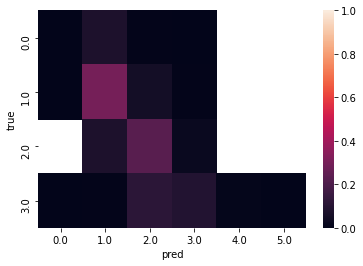

In [93]:
%%time

lm = LinearRegression()
lm.fit(X_train_sc, y_train)

print("Train score:", lm.score(X_train_sc, y_train))
print("Test score:", lm.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, np.round(lm.predict(X_test_sc)));

Train score: 0.5240383614938562
Test score: 0.488347536176994
CPU times: user 334 ms, sys: 152 ms, total: 486 ms
Wall time: 161 ms


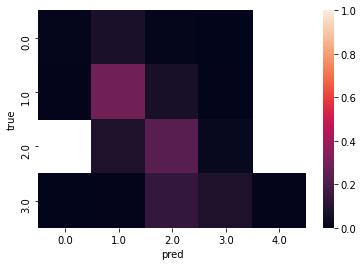

In [94]:
%%time

lm = LinearRegression()
lm.fit(Z_train, y_train)

print("Train score:", lm.score(Z_train, y_train))
print("Test score:", lm.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, np.round(lm.predict(Z_test)));

## LASSO

Winning param: 0.01
Train score: 0.5525114875078401
Test score: 0.5391850377831603
CPU times: user 656 ms, sys: 388 ms, total: 1.04 s
Wall time: 411 ms


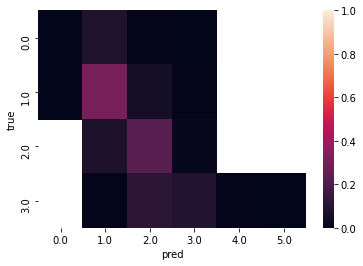

In [95]:
%%time

lasso_cv = LassoCV(alphas=[1e-1, 1e-2, 1e-3], cv=5, max_iter=5000)
lasso_cv.fit(X_train_sc, y_train);

print("Winning param:", lasso_cv.alpha_)
print("Train score:", lasso_cv.score(X_train_sc, y_train))
print("Test score:", lasso_cv.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, np.round(lasso_cv.predict(X_test_sc)));

Winning param: 0.001
Train score: 0.5240332557502692
Test score: 0.4885091074204009
CPU times: user 327 ms, sys: 208 ms, total: 535 ms
Wall time: 172 ms


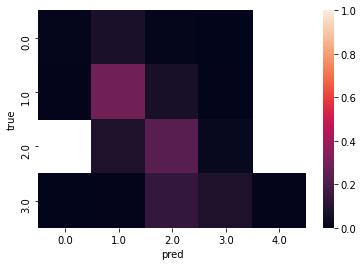

In [96]:
%%time

lasso_cv = LassoCV(alphas=[1e-1, 1e-2, 1e-3], cv=5, max_iter=5000)
lasso_cv.fit(Z_train, y_train);

print("Winning param:", lasso_cv.alpha_)
print("Train score:", lasso_cv.score(Z_train, y_train))
print("Test score:", lasso_cv.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, np.round(lasso_cv.predict(Z_test)));

0.01

## Naïve Bayes

Train score: 0.6018306636155606
Test score: 0.6064073226544623
CPU times: user 108 ms, sys: 40 ms, total: 148 ms
Wall time: 92 ms


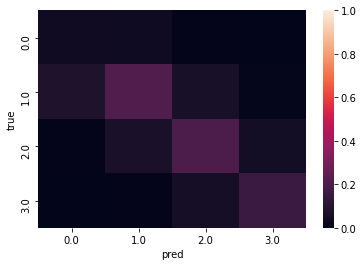

In [97]:
%%time

gnb = GaussianNB()
gnb.fit(X_train_sc, y_train)

print("Train score:", gnb.score(X_train_sc, y_train))
print("Test score:", gnb.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, gnb.predict(X_test_sc));

Train score: 0.5953470633104501
Test score: 0.5755148741418764
CPU times: user 108 ms, sys: 40 ms, total: 148 ms
Wall time: 89.1 ms


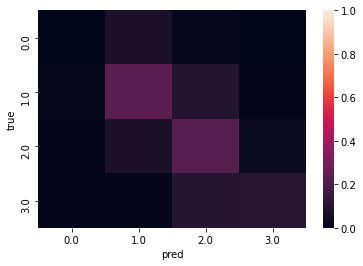

In [98]:
%%time

gnb = GaussianNB()
gnb.fit(Z_train, y_train)

print("Train score:", gnb.score(Z_train, y_train))
print("Test score:", gnb.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, gnb.predict(Z_test));

## Support vector machine

Winning params: {'C': 1.0}
Train score: 0.6636155606407322
Test score: 0.6418764302059496
CPU times: user 14.8 s, sys: 48.1 ms, total: 14.8 s
Wall time: 14.8 s


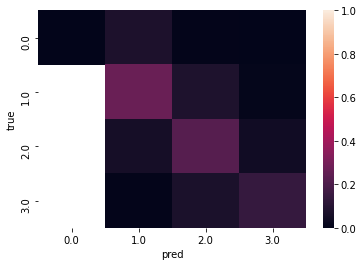

In [99]:
%%time

svm = SVC(random_state=seed, kernel="rbf")
svmg = GridSearchCV(svm, {
    "C": np.logspace(0, 2, 10)
})
svmg.fit(X_train_sc, y_train)

print("Winning params:", svmg.best_params_)
print("Train score:", svmg.score(X_train_sc, y_train))
print("Test score:", svmg.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, svmg.predict(X_test_sc));

Train score: 0.6350114416475973
Test score: 0.6121281464530892
CPU times: user 618 ms, sys: 52 ms, total: 670 ms
Wall time: 572 ms


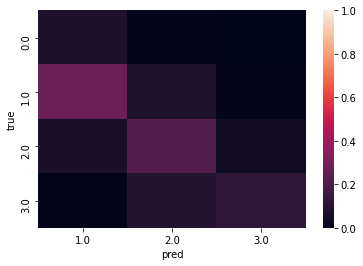

In [100]:
%%time

svm = SVC(random_state=seed, C=1)
svm.fit(Z_train, y_train)

print("Train score:", svm.score(Z_train, y_train))
print("Test score:", svm.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, svm.predict(Z_test));

## Extra Trees

Winning params: {'max_depth': 300, 'n_estimators': 1000}
Train score: 0.9996186117467581
Test score: 0.6304347826086957
CPU times: user 2min 9s, sys: 1.18 s, total: 2min 10s
Wall time: 2min 10s


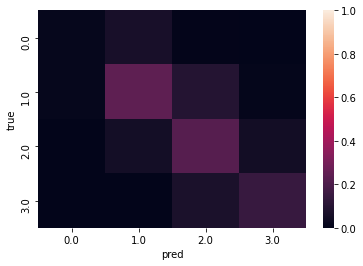

In [101]:
%%time

ext = ExtraTreesClassifier()
extg = GridSearchCV(ext, {
    "n_estimators": [1000, 2000],
    "max_depth": [200, 300, 400],
})
extg.fit(X_train_sc, y_train)

print("Winning params:", extg.best_params_)
print("Train score:", extg.score(X_train_sc, y_train))
print("Test score:", extg.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, extg.predict(X_test_sc));

In [ ]:
%%time

ext = ExtraTreesClassifier()
ext.fit(Z_train, y_train)

print("Train score:", ext.score(Z_train, y_train))
print("Test score:", ext.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, ext.predict(Z_test));

## AdaBoost

Train score: 0.581998474446987
Test score: 0.580091533180778
CPU times: user 1.9 s, sys: 39.5 ms, total: 1.94 s
Wall time: 1.83 s


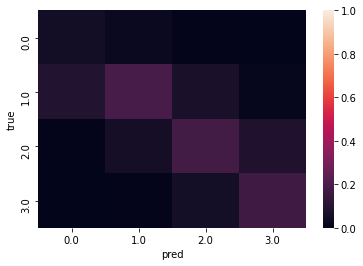

In [31]:
%%time

ada = AdaBoostClassifier()
ada.fit(X_train_sc, y_train)

print("Train score:", ada.score(X_train_sc, y_train))
print("Test score:", ada.score(X_test_sc, y_test))
multiaccuracy_heatmap(y_test, ada.predict(X_test_sc));

Train score: 0.5758962623951183
Test score: 0.5354691075514875
CPU times: user 774 ms, sys: 59 ms, total: 833 ms
Wall time: 729 ms


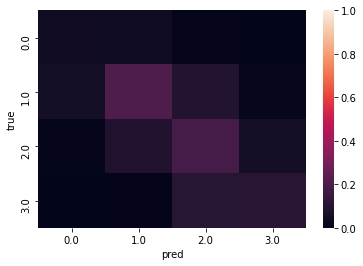

In [28]:
%%time

ada = AdaBoostClassifier()
ada.fit(Z_train, y_train)

print("Train score:", ada.score(Z_train, y_train))
print("Test score:", ada.score(Z_test, y_test))
multiaccuracy_heatmap(y_test, ada.predict(Z_test));

# Write out model

In [105]:
dump(svmg, "../EssayScorer/model.svm", compress=True)

['../EssayScorer/model.svm']

In [116]:
y_test

1134    3.0
2677    1.0
1047    3.0
1861    3.0
1280    1.0
       ... 
2431    2.0
2087    1.0
854     1.0
2058    1.0
129     1.0
Name: score, Length: 874, dtype: float64

In [121]:
X_test[(X_test["types"] < 50) & (y_test == 3)]

,tokens,types,sent_len,word_len,freq,semicolons,link_words,pps,max_depth,essay
483,74.0,44.0,18.500000,4.027027,78576.0,0.0,0.0,1.067568,6.0,The features of the setting affect the cyclist...
1690,33.0,24.0,11.000000,3.575758,13519.0,0.0,0.0,1.090909,5.0,He is going on a journey on his bike. He has t...
819,51.0,32.0,7.285714,3.941176,64460.0,0.0,0.0,1.137255,5.0,"Snake, heat, hills-all are what the biker had ..."
2917,17.0,15.0,17.000000,4.117647,1347.0,0.0,0.0,1.058824,5.0,Because she saying when the @CAPS1 grow back s...


In [127]:
X_test.loc[1690, "essay"]

'He is going on a journey on his bike. He has to go down hills and deal with the factt that has has no water. That’s basically what the setting is about.'